In [ ]:
import os

from dotenv import load_dotenv

load_dotenv()
import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn" # —Ç–∞–±–ª–∏—Ü–∞ —Å –¥–∞–Ω–Ω—ã–º–∏ –≤ postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5001

EXPERIMENT_NAME = "churn_prediction_experiment_budikdb" # –Ω–∞–ø–∏—à–∏—Ç–µ –Ω–∞–∑–≤–∞–Ω–∏–µ –≤–∞—à–µ–≥–æ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞
RUN_NAME = "eda"


pd.options.display.max_columns = 100
pd.options.display.max_rows = 64


# –°–æ–∑–¥–∞–µ–º –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é assets –≤ –ø–∞–ø–∫–µ mle-mlflow
ASSETS_DIR = "assets"
os.makedirs(ASSETS_DIR, exist_ok=True) # —Å–æ–∑–¥–∞–µ—Ç –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—é, –µ—Å–ª–∏ –æ–Ω–∞ –µ—â–µ –Ω–µ —Å—É—â–µ—Å—Ç–≤—É–µ—Ç

sns.set_style("white")
sns.set_theme(style="whitegrid")

connection = {
    "sslmode": "require",
    "target_session_attrs": "read-write",
    "connect_timeout": 10
}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

id customer_id begin_date end_date      type paperless_billing  \
0  12  7469-LKBCI 2018-10-01      NaT  Two year                No   
1  13  8091-TTVAX 2015-04-01      NaT  One year                No   

            payment_method  monthly_charges  total_charges internet_service  \
0  Credit card (automatic)            18.95          326.8             None   
1  Credit card (automatic)           100.35         5681.1      Fiber optic   

  online_security online_backup device_protection tech_support streaming_tv  \
0            None          None              None         None         None   
1              No            No               Yes           No          Yes   

  streaming_movies gender  senior_citizen partner dependents multiple_lines  \
0             None   Male               0      No         No             No   
1              Yes   Male               0     Yes         No            Yes   

   target  
0       0  
1       0

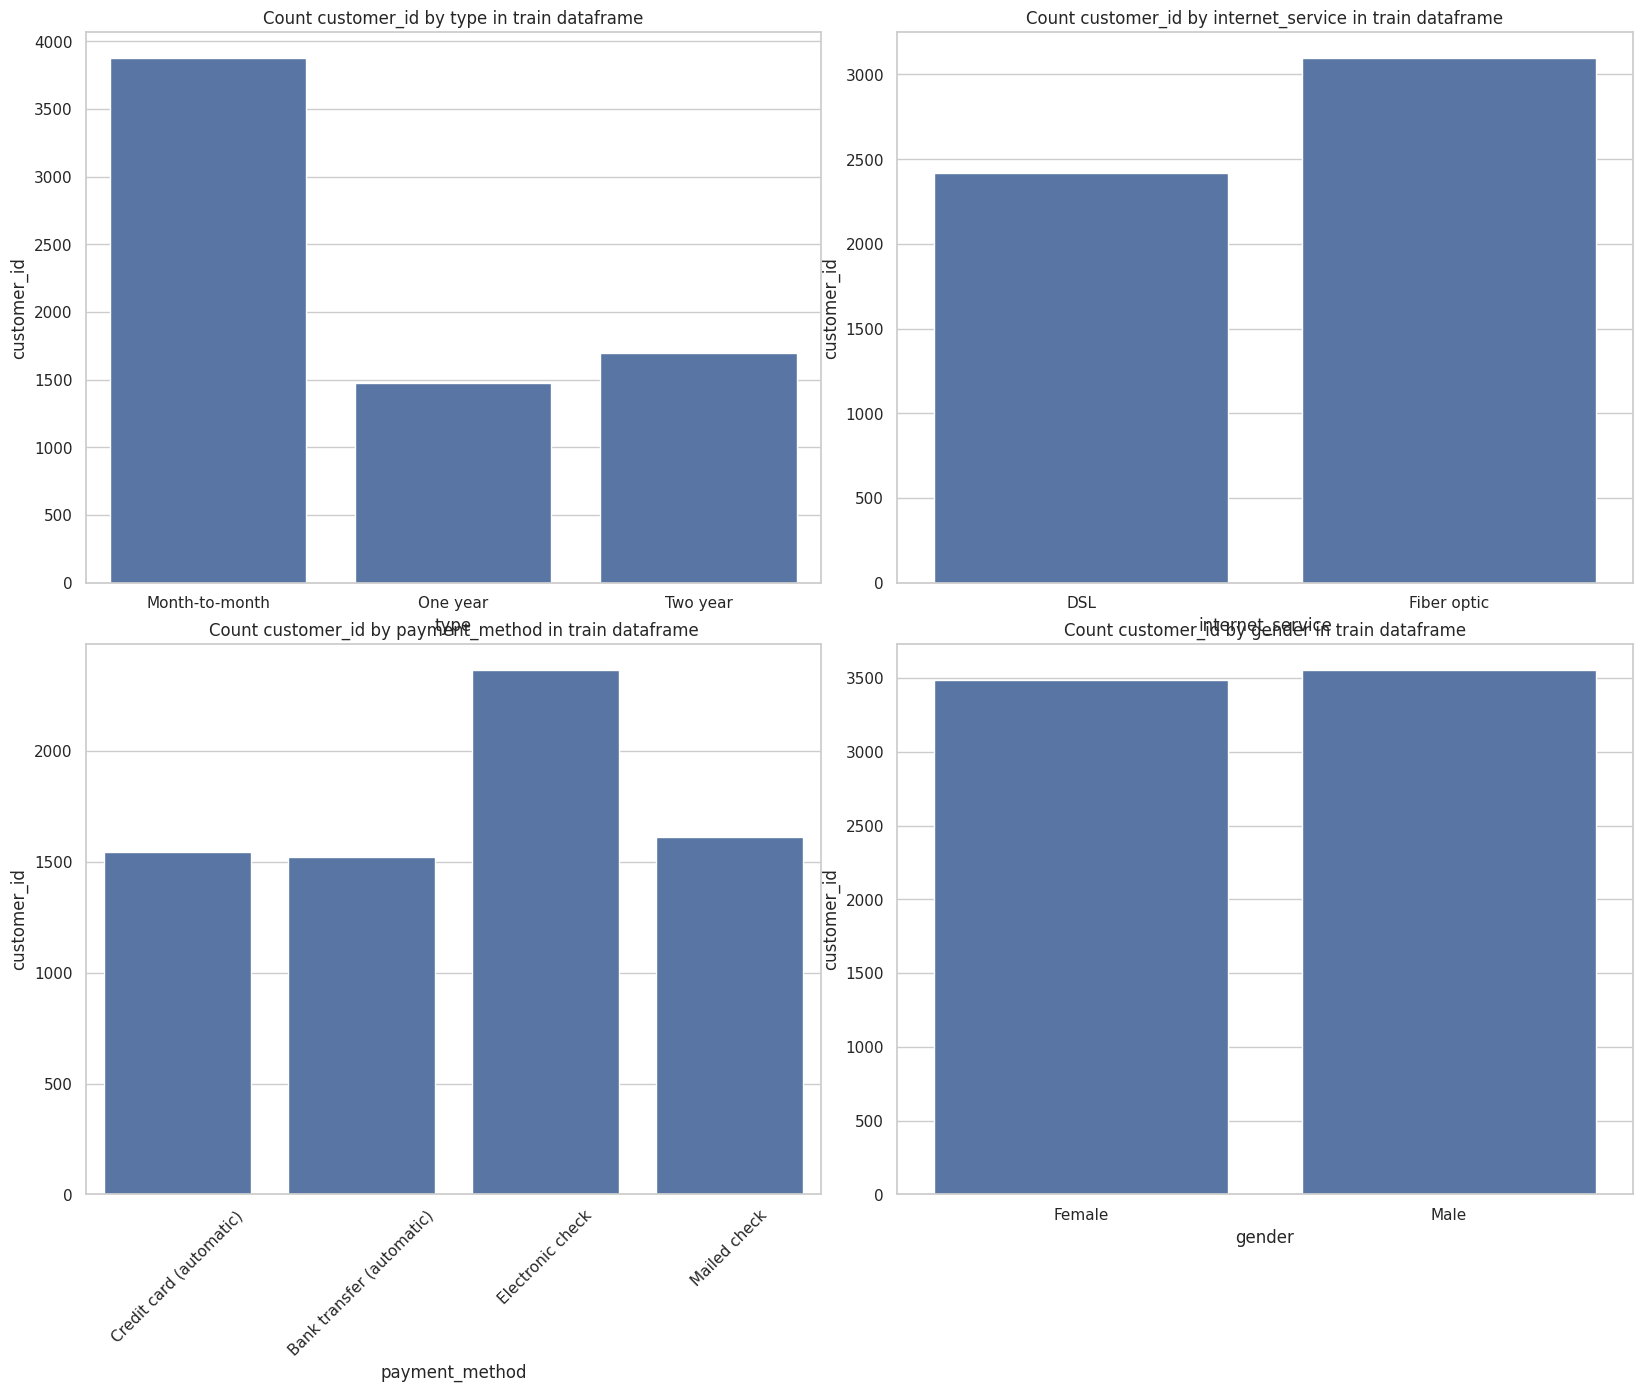

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16.5, 12.5))
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)

x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticks(range(len(df[x].unique())))  # –£—Å—Ç–∞–Ω–æ–≤–∏—Ç—å –ø–æ–∑–∏—Ü–∏–∏ —Ç–∏–∫–æ–≤
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1.png'))

In [13]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = "count"
print(df.groupby(binary_columns).agg(stat)[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv  \
0                No            No                No           No           No   
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

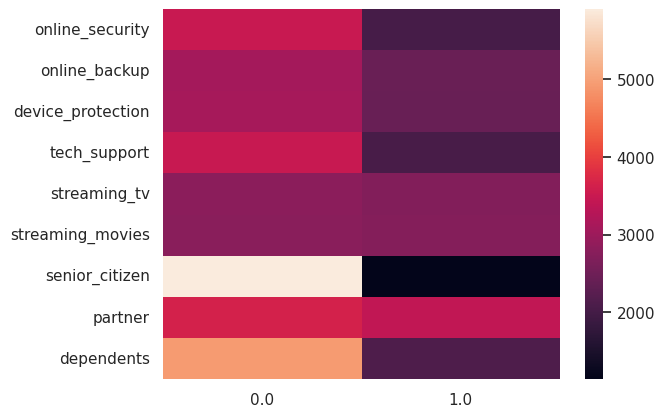

In [14]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º Yes/No –≤ 1/0 –¥–ª—è –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ–≥–æ –ø–æ–¥—Å—á–µ—Ç–∞
df_binary = df[binary_columns].replace({'Yes': 1, 'No': 0})

# –¢–µ–ø–µ—Ä—å —Å—Ç—Ä–æ–∏–º heatmap
heat_df = df_binary.apply(pd.Series.value_counts).T
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


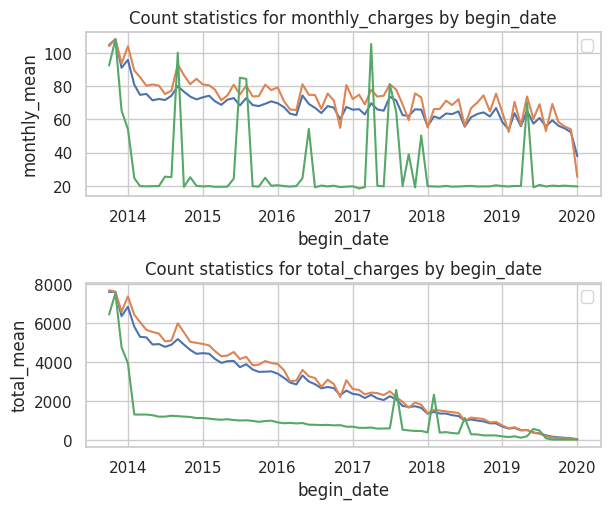

In [15]:
# –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –¥–ª—è –Ω–∞–∑–≤–∞–Ω–∏—è –∫–æ–ª–æ–Ω–∫–∏
x = "begin_date"

# —Å–ø–∏—Å–æ–∫ –∫–æ–ª–æ–Ω–æ–∫, –¥–ª—è –∫–æ—Ç–æ—Ä—ã—Ö –±—É–¥—É—Ç –≤—ã—á–∏—Å–ª—è—Ç—å—Å—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# —É–¥–∞–ª–µ–Ω–∏–µ –ø—É—Å—Ç—ã—Ö –∫–æ–ª–æ–Ω–æ–∫ –¥–ª—è –ø–æ—Å—á—ë—Ç–∞ –º–µ–¥–∏–∞–Ω–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è
df.dropna(subset=charges_columns, how='any', inplace=True)

# —Å–ø–∏—Å–æ–∫ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫, –∫–æ—Ç–æ—Ä—ã–µ –±—É–¥—É—Ç –≤—ã—á–∏—Å–ª—è—Ç—å—Å—è –¥–ª—è –∫–∞–∂–¥–æ–π –≥—Ä—É–ø–ø—ã
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # —Å—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ, –º–µ–¥–∏–∞–Ω–∞ –∏ –º–æ–¥–∞

# –≥—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –ø–æ –¥–∞—Ç–µ –Ω–∞—á–∞–ª–∞ –∏ –∞–≥—Ä–µ–≥–∞—Ü–∏—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫ –¥–ª—è –µ–∂–µ–º–µ—Å—è—á–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π (–∏—Å–ø–æ–ª—å–∑—É–π—Ç–µ reset_index –¥–ª—è —Å–±—Ä–æ—Å–∞ –∏–Ω–¥–µ–∫—Å–∞ –≤ —Ç–∞–±–ª–∏—Ü–µ)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# —É–¥–∞–ª–µ–Ω–∏–µ –≤–µ—Ä—Ö–Ω–µ–≥–æ —É—Ä–æ–≤–Ω—è –∏–Ω–¥–µ–∫—Å–∞ –∫–æ–ª–æ–Ω–æ–∫ (–ø–æ—Å–ª–µ –∞–≥—Ä–µ–≥–∞—Ü–∏–∏)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# –ø–µ—Ä–µ–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ –∫–æ–ª–æ–Ω–æ–∫ –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞ –≤–æ—Å–ø—Ä–∏—è—Ç–∏—è
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# –∞–Ω–∞–ª–æ–≥–∏—á–Ω–æ –¥–ª—è –æ–±—â–∏—Ö –ø–ª–∞—Ç–µ–∂–µ–π
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# —Å–æ–∑–¥–∞–Ω–∏–µ –æ–±—ä–µ–∫—Ç–∞ –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–æ–≤ (2 –≥—Ä–∞—Ñ–∏–∫–∞ –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω–æ)
fig, axs = plt.subplots(2, 1)
# –Ω–∞—Å—Ç—Ä–æ–π–∫–∞ –æ—Ç—Å—Ç—É–ø–æ–≤ –º–µ–∂–¥—É –≥—Ä–∞—Ñ–∏–∫–∞–º–∏
fig.tight_layout(pad=2.5)
# —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Ä–∞–∑–º–µ—Ä–∞ —Ñ–∏–≥—É—Ä—ã
fig.set_size_inches(6.5, 5.5, forward=True)

# –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –ª–∏–Ω–µ–π–Ω—ã—Ö –≥—Ä–∞—Ñ–∏–∫–æ–≤ –¥–ª—è –µ–∂–µ–º–µ—Å—è—á–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
axs[0].legend()
# —É—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ –¥–ª—è –≤–µ—Ä—Ö–Ω–µ–≥–æ –≥—Ä–∞—Ñ–∏–∫–∞
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –ª–∏–Ω–µ–π–Ω—ã—Ö –≥—Ä–∞—Ñ–∏–∫–æ–≤ –¥–ª—è –æ–±—â–∏—Ö –ø–ª–∞—Ç–µ–∂–µ–π
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
axs[1].legend()

# —É—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ –¥–ª—è –Ω–∏–∂–Ω–µ–≥–æ –≥—Ä–∞—Ñ–∏–∫–∞
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞ –≤ —Ñ–∞–π–ª
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

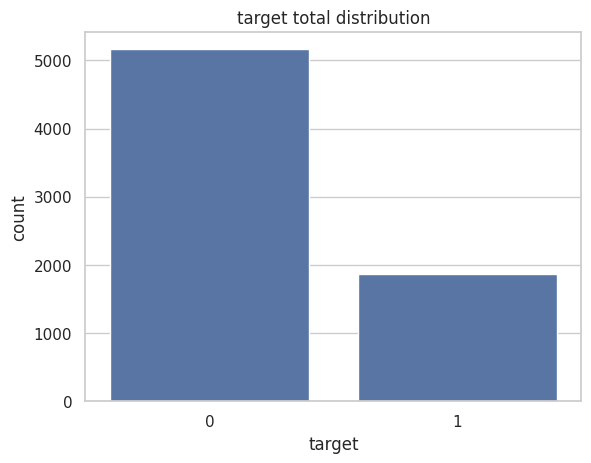

In [16]:
# –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –∫–∞—Ä—Ç–∏–Ω–æ–∫
ASSETS_DIR = "assets"  # –∏–ª–∏ —É–∫–∞–∂–∏—Ç–µ –≤–∞—à –ø—É—Ç—å –∫ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏ —Å –∞—Ä—Ç–µ—Ñ–∞–∫—Ç–∞–º–∏

# —É—Å—Ç–∞–Ω–æ–≤–∫–∞ –Ω–∞–∑–≤–∞–Ω–∏—è –∫–æ–ª–æ–Ω–∫–∏ –¥–ª—è –∞–≥—Ä–µ–≥–∞—Ü–∏–∏
x = "target"

# –ø–æ–¥—Å—á—ë—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∫–∞–∂–¥–æ–≥–æ —É–Ω–∏–∫–∞–ª—å–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è –≤ –∫–æ–ª–æ–Ω–∫–µ –∏ —Å–±—Ä–æ—Å –∏–Ω–¥–µ–∫—Å–∞ –¥–ª—è –ø–æ—Å–ª–µ–¥—É—é—â–µ–π –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
target_agg = df[x].value_counts().reset_index()
target_agg.columns = ['target', 'count']


# —Å–æ–∑–¥–∞–Ω–∏–µ —Å—Ç–æ–ª–±—á–∞—Ç–æ–π –¥–∏–∞–≥—Ä–∞–º–º—ã –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
sns.barplot(data=target_agg, x='target', y='count')

# —É—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ –≥—Ä–∞—Ñ–∏–∫–∞
plt.title(f"{x} total distribution")

# —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞ –≤ —Ñ–∞–π–ª
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

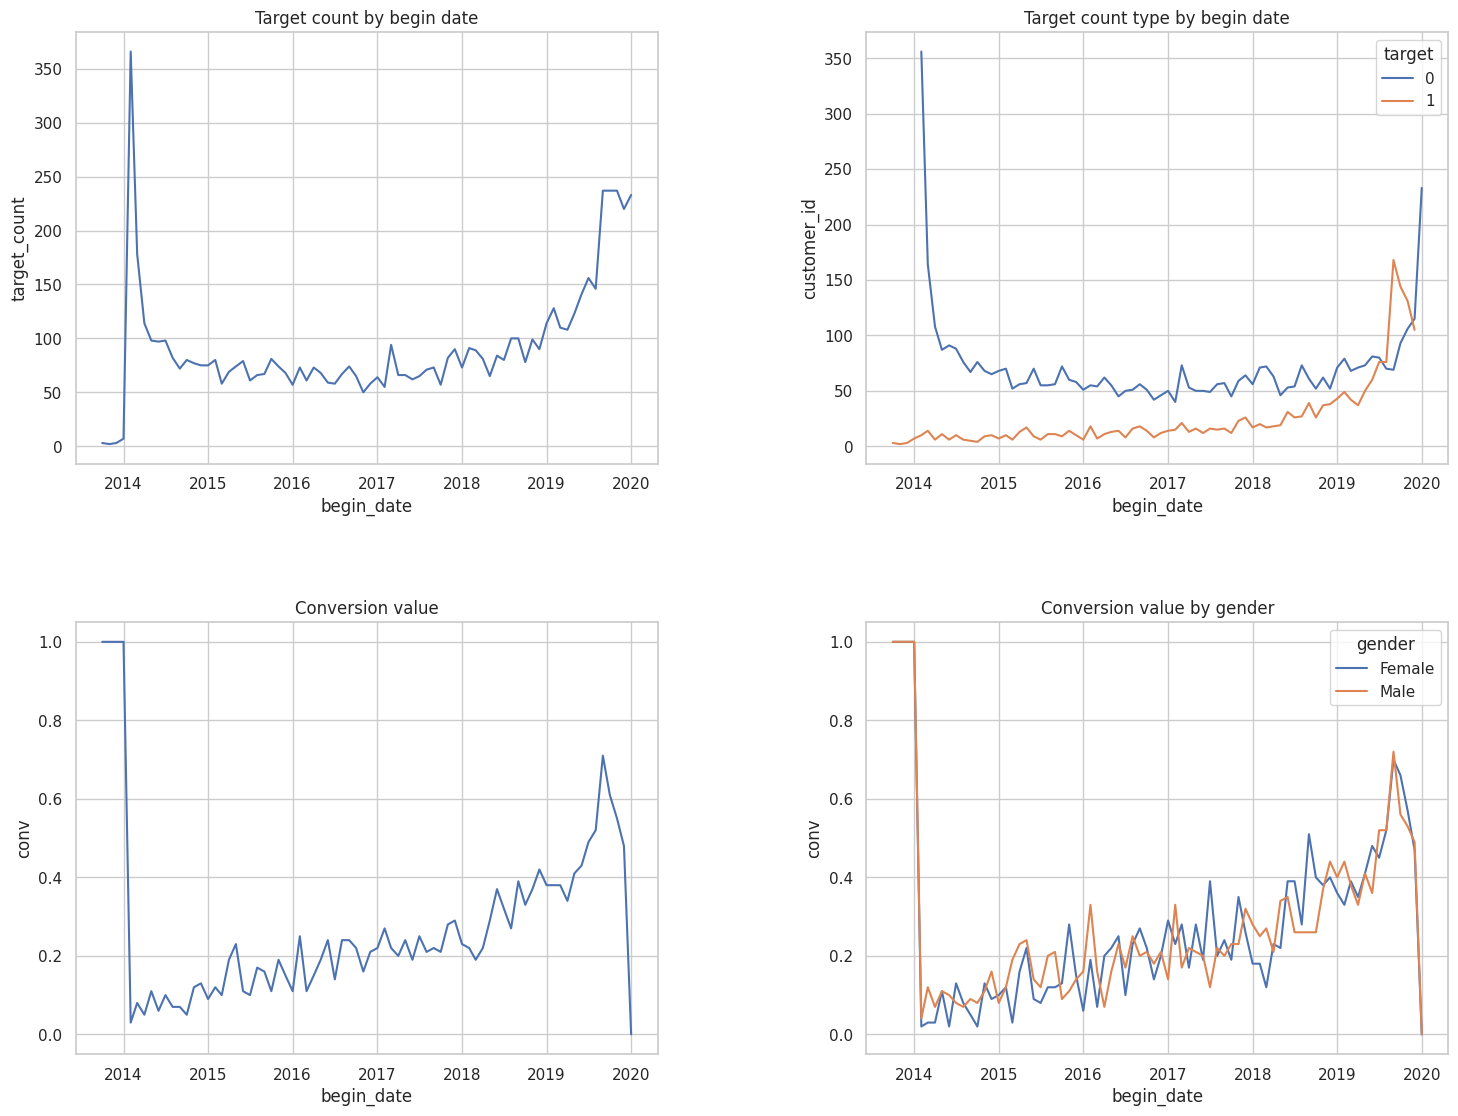

In [17]:
# —É—Å—Ç–∞–Ω–æ–≤–∫–∞ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞
x = "begin_date"
target = "target"

# –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏ –¥–ª—è –∞–≥—Ä–µ–≥–∞—Ü–∏–∏
stat = "count"

# –∞–≥—Ä–µ–≥–∞—Ü–∏—è –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ü–µ–ª–µ–π –ø–æ –¥–∞—Ç–∞–º –Ω–∞—á–∞–ª–∞ —Å –ø–æ—Å–ª–µ–¥—É—é—â–∏–º —Å–±—Ä–æ—Å–æ–º –∏–Ω–¥–µ–∫—Å–∞
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# —É–¥–∞–ª–µ–Ω–∏–µ –º—É–ª—å—Ç–∏—É—Ä–æ–≤–Ω–µ–≤–æ—Å—Ç–∏ –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤ –ø–æ—Å–ª–µ –∞–≥—Ä–µ–≥–∞—Ü–∏–∏ –∏ –ø–µ—Ä–µ–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞
target_agg_by_date.columns = [x, "target_count"]

# –ø–æ–¥—Å—á—ë—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∫–ª–∏–µ–Ω—Ç–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è —Ü–µ–ª–∏ –ø–æ –¥–∞—Ç–∞–º
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# —Ä–∞—Å—á—ë—Ç —Å—É–º–º—ã –∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –¥–ª—è –∫–æ–Ω–≤–µ—Ä—Å–∏–∏ –ø–æ –¥–∞—Ç–∞–º
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# –≤—ã—á–∏—Å–ª–µ–Ω–∏–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ –∫–æ–Ω–≤–µ—Ä—Å–∏–∏ –∏ –æ–∫—Ä—É–≥–ª–µ–Ω–∏–µ –¥–æ –¥–≤—É—Ö –∑–Ω–∞–∫–æ–≤
conversion_agg["conv"] = (conversion_agg["sum"] / conversion_agg["count"]).round(2)

# –∞–Ω–∞–ª–æ–≥–∏—á–Ω—ã–π —Ä–∞—Å—á–µ—Ç –∫–æ–Ω–≤–µ—Ä—Å–∏–∏, –Ω–æ —Å –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–º —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ–º –ø–æ –ø–æ–ª—É
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender["conv"] = (conversion_agg_gender["sum"] / conversion_agg_gender["count"]).round(2)

# –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è —Ñ–∏–≥—É—Ä—ã –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö –≥—Ä–∞—Ñ–∏–∫–æ–≤
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # –Ω–∞—Å—Ç—Ä–æ–π–∫–∞ –æ—Ç—Å—Ç—É–ø–æ–≤ –º–µ–∂–¥—É –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–∞–º–∏
fig.set_size_inches(16.5, 12.5, forward=True)  # —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Ä–∞–∑–º–µ—Ä–∞ —Ñ–∏–≥—É—Ä—ã

# –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –æ–±—â–µ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ü–µ–ª–µ–π –ø–æ –¥–∞—Ç–∞–º –Ω–∞—á–∞–ª–∞
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∫–ª–∏–µ–Ω—Ç–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ç–∏–ø–∞ —Ü–µ–ª–∏ –ø–æ –¥–∞—Ç–∞–º
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ –∫–æ–Ω–≤–µ—Ä—Å–∏–∏ –ø–æ –¥–∞—Ç–∞–º
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ –∫–æ–Ω–≤–µ—Ä—Å–∏–∏ –ø–æ –¥–∞—Ç–∞–º —Å —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ–º –ø–æ –ø–æ–ª—É
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue="gender", ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ –≤ —Ñ–∞–π–ª
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

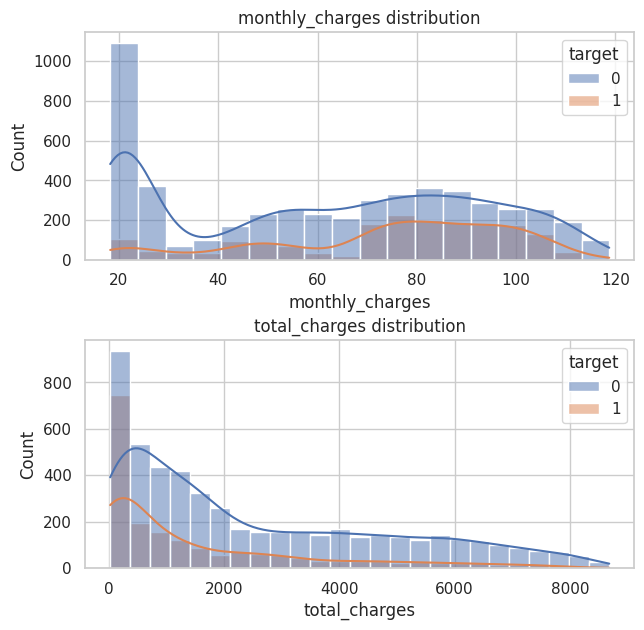

In [18]:
# –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–ø–∏—Å–∫–∞ —Å—Ç–æ–ª–±—Ü–æ–≤ —Å –¥–∞–Ω–Ω—ã–º–∏ –æ –ø–ª–∞—Ç–µ–∂–∞—Ö –∏ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
charges = ["monthly_charges", "total_charges"]
target = "target"

# –∏–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è —Ñ–∏–≥—É—Ä—ã –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # –Ω–∞—Å—Ç—Ä–æ–π–∫–∞ –æ—Ç—Å—Ç—É–ø–æ–≤ –º–µ–∂–¥—É –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–∞–º–∏
fig.set_size_inches(6.5, 6.5, forward=True)  # —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Ä–∞–∑–º–µ—Ä–∞ —Ñ–∏–≥—É—Ä—ã

# –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –µ–∂–µ–º–µ—Å—è—á–Ω—ã—Ö –ø–ª–∞—Ç–µ–∂–µ–π —Å —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ–º –ø–æ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
sns.histplot(data=df, x=charges[0], hue=target, kde=True, ax=axs[0])
# –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å –¥–∞–Ω–Ω—ã–º–∏
# –ø–µ—Ä–≤—ã–π –≤–∏–¥ –ø–ª–∞—Ç–µ–∂–µ–π –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
# —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –ø–æ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
# –≤–∫–ª—é—á–µ–Ω–∏–µ –æ—Ü–µ–Ω–∫–∏ –ø–ª–æ—Ç–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è (Kernel Density Estimate)
# —É–∫–∞–∑–∞–Ω–∏–µ, –Ω–∞ –∫–∞–∫–æ–º –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–µ –æ—Ç–æ–±—Ä–∞–∑–∏—Ç—å –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É
axs[0].set_title(f"{charges[0]} distribution")  # —É—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ –¥–ª—è –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã

# –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –æ–±—â–∏—Ö –ø–ª–∞—Ç–µ–∂–µ–π —Å —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ–º –ø–æ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
sns.histplot(data=df, x=charges[1], hue=target, kde=True, ax=axs[1])
# –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å –¥–∞–Ω–Ω—ã–º–∏
# –≤—Ç–æ—Ä–æ–π –≤–∏–¥ –ø–ª–∞—Ç–µ–∂–µ–π –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
# —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –ø–æ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
# –≤–∫–ª—é—á–µ–Ω–∏–µ –æ—Ü–µ–Ω–∫–∏ –ø–ª–æ—Ç–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
# —É–∫–∞–∑–∞–Ω–∏–µ, –Ω–∞ –∫–∞–∫–æ–º –ø–æ–¥–≥—Ä–∞—Ñ–∏–∫–µ –æ—Ç–æ–±—Ä–∞–∑–∏—Ç—å –≤—Ç–æ—Ä—É—é –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É
axs[1].set_title(f"{charges[1]} distribution")  # –£—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ –¥–ª—è –≤—Ç–æ—Ä–æ–π –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—ã

# —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ñ–∏–≥—É—Ä—ã —Å –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞–º–∏ –≤ —Ñ–∞–π–ª
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [1]:
import os
import dotenv

dotenv.load_dotenv()

print(os.getenv("MLFLOW_S3_ENDPOINT_URL"))

# –ó–∞–≥—Ä—É–∂–∞–µ–º –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –∏ –ø–æ–ª—É—á–∞–µ–º —Å–ª–æ–≤–∞—Ä—å
env_vars = dotenv.dotenv_values()

print("–ü–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –∏–∑ .env —Ñ–∞–π–ª–∞:")
##for key, value in env_vars.items():
##    print(f"{key} = {value}")

https://storage.yandexcloud.net
–ü–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –∏–∑ .env —Ñ–∞–π–ª–∞:


In [ ]:
import os
import dotenv

dotenv.load_dotenv()

TABLE_NAME = "users_churn" # —Ç–∞–±–ª–∏—Ü–∞ —Å –¥–∞–Ω–Ω—ã–º–∏ –≤ postgres 

TRACKING_SERVER_HOST = "0.0.0.0"
TRACKING_SERVER_PORT = 5001

EXPERIMENT_NAME = "churn_prediction_experiment_budikdb" # –Ω–∞–ø–∏—à–∏—Ç–µ –Ω–∞–∑–≤–∞–Ω–∏–µ –≤–∞—à–µ–≥–æ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞
RUN_NAME = "eda"

os.environ["MLFLOW_S3_ENDPOINT_URL"] =  "***"
os.environ["AWS_ACCESS_KEY_ID"] = "***"
os.environ["AWS_SECRET_ACCESS_KEY"] = "***"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
ASSETS_DIR = "assets"
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR)

üèÉ View run eda at: http://0.0.0.0:5001/#/experiments/5/runs/56768802199c48d2a221400d39b92822
üß™ View experiment at: http://0.0.0.0:5001/#/experiments/5


S3UploadFailedError: Failed to upload /home/mle-user/mle_projects/mle-mlflow/assets/cat_features_2_binary_heatmap.png to s3-student-mle-20250130-d1608e0ec6/5/56768802199c48d2a221400d39b92822/artifacts/cat_features_2_binary_heatmap.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.